<a href="https://colab.research.google.com/github/Sarah-Shitrit/FashionMNIST/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and downloads
Were assisted by Udacity's course: Intro to Deep Learning with PyTorch https://www.udacity.com/course/deep-learning-pytorch--ud188

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Important! Insert the path to the folder in which the models' parameters are saved
models_path = '/content/drive/MyDrive/Deep Learning Course/HW1'

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Networks

## LENET-5, LENET-5 with wd

In [ ]:
# Build network, LENET-5
class LENET5(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Conv2d(1, 6, 5, padding='same')
    self.fc2 = nn.MaxPool2d(2, stride=2)
    self.fc3 = nn.Conv2d(6, 16, 5)
    self.fc4 = nn.MaxPool2d(2, stride=2)
    self.fc5 = nn.Conv2d(16, 120, 5)
    self.fc6 = nn.Linear(120, 84)
    self.fc7 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1) 

    return x

## LENET-5 with dropout

In [ ]:
# LENET-5 with dropout
class LENET5_dropout(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Conv2d(1, 6, 5, padding='same')
    self.fc2 = nn.MaxPool2d(2, stride=2)
    self.fc3 = nn.Conv2d(6, 16, 5)
    self.fc4 = nn.MaxPool2d(2, stride=2)
    self.fc5 = nn.Conv2d(16, 120, 5)
    self.fc6 = nn.Linear(120, 84)
    self.fc7 = nn.Linear(84, 10)

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    x = F.relu(self.fc5(x))
    x = self.dropout(x)
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1) 

    return x

## LENET-5 with BN

In [ ]:
# LENET-5, BN
class LENET5_bn(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Conv2d(1, 6, 5, padding='same')
    self.fc1_bn = nn.BatchNorm2d(6)

    self.fc2 = nn.MaxPool2d(2, stride=2)
    self.fc2_bn = nn.BatchNorm2d(6)

    self.fc3 = nn.Conv2d(6, 16, 5)
    self.fc3_bn = nn.BatchNorm2d(16)

    self.fc4 = nn.MaxPool2d(2, stride=2)
    self.fc4_bn = nn.BatchNorm2d(16)
    
    self.fc5 = nn.Conv2d(16, 120, 5)
    self.fc5_bn = nn.BatchNorm2d(120)
    
    self.fc6 = nn.Linear(120, 84)
    self.fc6_bn = nn.BatchNorm1d(84)
    
    self.fc7 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(self.fc1_bn(x))
    x = self.fc2(x)
    x = F.relu(self.fc2_bn(x))
    x = self.fc3(x)
    x = F.relu(self.fc3_bn(x))
    x = self.fc4(x)
    x = F.relu(self.fc4_bn(x))
    x = self.fc5(x)
    x = F.relu(self.fc5_bn(x))
    x = x.view(x.shape[0], -1)
    x = self.fc6(x)
    x = F.relu(self.fc6_bn(x))
    x = F.log_softmax(self.fc7(x), dim=1) 

    return x

# Train and save data of best models

## No regularization

In [ ]:
# Train network - LENET-5

model = LENET5()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30

train_losses_lenet5, test_losses_lenet5 = [], []
accuracy_train_lenet5, accuracy_test_lenet5 = [], []
best_accuracy = 0

for e in range(epochs):
  running_loss = 0
  accuracy_train = 0
  for images, labels in trainloader:
    
    optimizer.zero_grad()

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_train += torch.mean(equals.type(torch.FloatTensor))


  else:
    test_loss = 0
    accuracy_test = 0
    counter = 0

    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy_test += torch.mean(equals.type(torch.FloatTensor))

    model.train()

    train_losses_lenet5.append(running_loss/len(trainloader))
    test_losses_lenet5.append(test_loss/len(testloader))
    accuracy_train_lenet5.append(accuracy_train / len(trainloader))
    accuracy_test_lenet5.append(accuracy_test / len(testloader))

    # Save model parameters
    if (accuracy_test / len(testloader)) > best_accuracy:
      torch.save(model.state_dict(), models_path +'/lenet5.pth')
      best_accuracy = accuracy_test / len(testloader)

    print ("Epoch: {}/{}..".format(e+1, epochs),
           "Training loss: {:.3f}..".format(train_losses_lenet5[-1]),
           "Test loss: {:.3f}..".format(test_losses_lenet5[-1]),
           "Train Accuracy: {:.3f}".format(accuracy_train / len(trainloader)),
           "Test Accuracy: {:.3f}..".format(accuracy_test / len(testloader)))
    
torch.save((accuracy_train_lenet5, accuracy_test_lenet5), models_path + '/accuracies_lenet5.pth')

tensor(0.8406)
Epoch: 1/30.. Training loss: 0.604.. Test loss: 0.436.. Train Accuracy: 0.775 Test Accuracy: 0.841..
tensor(0.8661)
Epoch: 2/30.. Training loss: 0.385.. Test loss: 0.376.. Train Accuracy: 0.857 Test Accuracy: 0.866..
tensor(0.8777)
Epoch: 3/30.. Training loss: 0.333.. Test loss: 0.339.. Train Accuracy: 0.876 Test Accuracy: 0.878..
tensor(0.8830)
Epoch: 4/30.. Training loss: 0.301.. Test loss: 0.320.. Train Accuracy: 0.889 Test Accuracy: 0.883..
tensor(0.8838)
Epoch: 5/30.. Training loss: 0.280.. Test loss: 0.324.. Train Accuracy: 0.895 Test Accuracy: 0.884..
tensor(0.8894)
Epoch: 6/30.. Training loss: 0.261.. Test loss: 0.305.. Train Accuracy: 0.903 Test Accuracy: 0.889..
tensor(0.8895)
Epoch: 7/30.. Training loss: 0.248.. Test loss: 0.305.. Train Accuracy: 0.906 Test Accuracy: 0.890..
tensor(0.8938)
Epoch: 8/30.. Training loss: 0.233.. Test loss: 0.289.. Train Accuracy: 0.913 Test Accuracy: 0.894..
tensor(0.8954)
Epoch: 9/30.. Training loss: 0.221.. Test loss: 0.291.. T

## Weight Decay

In [ ]:
# Train network - wd

model = LENET5()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

epochs = 30

train_losses_wd, test_losses_wd = [], []
accuracy_train_wd, accuracy_test_wd = [], []
best_accuracy = 0

for e in range(epochs):
  running_loss = 0
  accuracy_train = 0
  for images, labels in trainloader:
    
    optimizer.zero_grad()

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_train += torch.mean(equals.type(torch.FloatTensor))


  else:
    test_loss = 0
    accuracy_test = 0
    counter = 0

    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy_test += torch.mean(equals.type(torch.FloatTensor))

    model.train()

    train_losses_wd.append(running_loss/len(trainloader))
    test_losses_wd.append(test_loss/len(testloader))
    accuracy_train_wd.append(accuracy_train / len(trainloader))
    accuracy_test_wd.append(accuracy_test / len(testloader))

    # Save model parameters
    if (accuracy_test / len(testloader)) > best_accuracy:
      torch.save(model.state_dict(), models_path +'/lenet5_wd.pth')
      best_accuracy = accuracy_test / len(testloader)

    print ("Epoch: {}/{}..".format(e+1, epochs),
           "Training loss: {:.3f}..".format(train_losses_wd[-1]),
           "Test loss: {:.3f}..".format(test_losses_wd[-1]),
           "Train Accuracy: {:.3f}".format(accuracy_train / len(trainloader)),
           "Test Accuracy: {:.3f}..".format(accuracy_test / len(testloader)))
    
torch.save((accuracy_train_wd, accuracy_test_wd), models_path + '/accuracies_wd.pth')
           

Epoch: 1/30.. Training loss: 0.602.. Test loss: 0.445.. Train Accuracy: 0.779 Test Accuracy: 0.837..
Epoch: 2/30.. Training loss: 0.382.. Test loss: 0.360.. Train Accuracy: 0.859 Test Accuracy: 0.869..
Epoch: 3/30.. Training loss: 0.330.. Test loss: 0.349.. Train Accuracy: 0.879 Test Accuracy: 0.870..
Epoch: 4/30.. Training loss: 0.301.. Test loss: 0.312.. Train Accuracy: 0.891 Test Accuracy: 0.884..
Epoch: 5/30.. Training loss: 0.285.. Test loss: 0.313.. Train Accuracy: 0.896 Test Accuracy: 0.887..
Epoch: 6/30.. Training loss: 0.270.. Test loss: 0.290.. Train Accuracy: 0.902 Test Accuracy: 0.898..
Epoch: 7/30.. Training loss: 0.257.. Test loss: 0.277.. Train Accuracy: 0.906 Test Accuracy: 0.899..
Epoch: 8/30.. Training loss: 0.248.. Test loss: 0.285.. Train Accuracy: 0.910 Test Accuracy: 0.896..
Epoch: 9/30.. Training loss: 0.241.. Test loss: 0.284.. Train Accuracy: 0.912 Test Accuracy: 0.897..
Epoch: 10/30.. Training loss: 0.233.. Test loss: 0.268.. Train Accuracy: 0.915 Test Accurac

## Dropout

In [ ]:
# Train network - dropout
model = LENET5_dropout()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30

train_losses_dropout, test_losses_dropout = [], []
accuracy_train_dropout, accuracy_test_dropout = [], []
best_accuracy = 0

for e in range(epochs):
  running_loss = 0
  accuracy_train = 0
  for images, labels in trainloader:
    
    optimizer.zero_grad()

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_train += torch.mean(equals.type(torch.FloatTensor))


  else:
    test_loss = 0
    accuracy_test = 0
    counter = 0

    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy_test += torch.mean(equals.type(torch.FloatTensor))

    model.train()

    train_losses_dropout.append(running_loss/len(trainloader))
    test_losses_dropout.append(test_loss/len(testloader))
    accuracy_train_dropout.append(accuracy_train / len(trainloader))
    accuracy_test_dropout.append(accuracy_test / len(testloader))

    # Save model parameters
    if (accuracy_test / len(testloader)) > best_accuracy:
      torch.save(model.state_dict(), models_path +'/lenet5_dropout.pth')
      best_accuracy = accuracy_test / len(testloader)

    print ("Epoch: {}/{}..".format(e+1, epochs),
           "Training loss: {:.3f}..".format(train_losses_dropout[-1]),
           "Test loss: {:.3f}..".format(test_losses_dropout[-1]),
           "Train Accuracy: {:.3f}".format(accuracy_train / len(trainloader)),
           "Test Accuracy: {:.3f}..".format(accuracy_test / len(testloader)))
           
torch.save((accuracy_train_dropout, accuracy_test_dropout), models_path + '/accuracies_dropout.pth')

Epoch: 1/30.. Training loss: 0.682.. Test loss: 0.493.. Train Accuracy: 0.744 Test Accuracy: 0.828..
Epoch: 2/30.. Training loss: 0.466.. Test loss: 0.411.. Train Accuracy: 0.826 Test Accuracy: 0.857..
Epoch: 3/30.. Training loss: 0.416.. Test loss: 0.388.. Train Accuracy: 0.846 Test Accuracy: 0.865..
Epoch: 4/30.. Training loss: 0.389.. Test loss: 0.388.. Train Accuracy: 0.854 Test Accuracy: 0.872..
Epoch: 5/30.. Training loss: 0.374.. Test loss: 0.354.. Train Accuracy: 0.861 Test Accuracy: 0.874..
Epoch: 6/30.. Training loss: 0.359.. Test loss: 0.345.. Train Accuracy: 0.868 Test Accuracy: 0.877..
Epoch: 7/30.. Training loss: 0.351.. Test loss: 0.331.. Train Accuracy: 0.872 Test Accuracy: 0.884..
Epoch: 8/30.. Training loss: 0.340.. Test loss: 0.330.. Train Accuracy: 0.874 Test Accuracy: 0.885..
Epoch: 9/30.. Training loss: 0.332.. Test loss: 0.311.. Train Accuracy: 0.878 Test Accuracy: 0.889..
Epoch: 10/30.. Training loss: 0.329.. Test loss: 0.305.. Train Accuracy: 0.879 Test Accurac

## Batch Normalization 

In [ ]:
# Train network - bn
model = LENET5_bn()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 30

train_losses_bn, test_losses_bn = [], []
accuracy_train_bn, accuracy_test_bn = [], []
best_accuracy = 0


for e in range(epochs):
  running_loss = 0
  accuracy_train = 0
  for images, labels in trainloader:
    optimizer.zero_grad()

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_train += torch.mean(equals.type(torch.FloatTensor))


  else:
    test_loss = 0
    accuracy_test = 0
    counter = 0

    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy_test += torch.mean(equals.type(torch.FloatTensor))

    model.train()

    train_losses_bn.append(running_loss/len(trainloader))
    test_losses_bn.append(test_loss/len(testloader))
    accuracy_train_bn.append(accuracy_train / len(trainloader))
    accuracy_test_bn.append(accuracy_test / len(testloader))

    # Save model parameters
    if (accuracy_test / len(testloader)) > best_accuracy:
      torch.save(model.state_dict(), models_path +'/lenet5_bn.pth')
      best_accuracy = accuracy_test / len(testloader)

    print ("Epoch: {}/{}..".format(e+1, epochs),
           "Training loss: {:.3f}..".format(train_losses_bn[-1]),
           "Test loss: {:.3f}..".format(test_losses_bn[-1]),
           "Train Accuracy: {:.3f}".format(accuracy_train / len(trainloader)),
           "Test Accuracy: {:.3f}..".format(accuracy_test / len(testloader)))

torch.save((accuracy_train_bn, accuracy_test_bn), models_path + '/accuracies_bn.pth')

Epoch: 1/30.. Training loss: 0.446.. Test loss: 0.335.. Train Accuracy: 0.845 Test Accuracy: 0.876..
Epoch: 2/30.. Training loss: 0.296.. Test loss: 0.315.. Train Accuracy: 0.892 Test Accuracy: 0.884..
Epoch: 3/30.. Training loss: 0.259.. Test loss: 0.300.. Train Accuracy: 0.905 Test Accuracy: 0.893..
Epoch: 4/30.. Training loss: 0.234.. Test loss: 0.285.. Train Accuracy: 0.912 Test Accuracy: 0.896..
Epoch: 5/30.. Training loss: 0.216.. Test loss: 0.278.. Train Accuracy: 0.918 Test Accuracy: 0.898..
Epoch: 6/30.. Training loss: 0.201.. Test loss: 0.286.. Train Accuracy: 0.925 Test Accuracy: 0.902..
Epoch: 7/30.. Training loss: 0.187.. Test loss: 0.283.. Train Accuracy: 0.930 Test Accuracy: 0.901..
Epoch: 8/30.. Training loss: 0.173.. Test loss: 0.283.. Train Accuracy: 0.935 Test Accuracy: 0.902..
Epoch: 9/30.. Training loss: 0.163.. Test loss: 0.270.. Train Accuracy: 0.938 Test Accuracy: 0.909..
Epoch: 10/30.. Training loss: 0.152.. Test loss: 0.272.. Train Accuracy: 0.943 Test Accurac

# Load and test trained networks' parameters

## LENET-5, no regularization

In [ ]:
# Load LENET-5, no regularization
model = LENET5()
state_dict = torch.load(models_path + '/lenet5.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

## Weight Decay

In [ ]:
# Load LENET-5 with Weight Decay
model = LENET5()
state_dict = torch.load(models_path + '/lenet5_wd.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

## Dropout

In [ ]:
# Load LENET-5 with dropout
model = LENET5_dropout()
state_dict = torch.load(models_path + '/lenet5_dropout.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

## Batch Normalization

In [ ]:
# Load LENET-5 with Batch Normalization
model = LENET5_bn()
state_dict = torch.load(models_path + '/lenet5_bn.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

## Test
Run the test block after loading the desired model and its parameters to check its accuracy on a random batch

In [ ]:
# Test
model.eval()
images, labels = next((iter(testloader)))
log_ps = model(images)
ps = torch.exp(log_ps)
top_p, top_class = ps.topk(1, dim=1)
equals = top_class == labels.view(*top_class.shape)
accuracy = torch.mean(equals.type(torch.FloatTensor))
print("The accuracy is {}%, tested on a random batch".format(accuracy*100))

The accuracy is 84.375%, tested on a random batch


# Plots and Accuracy table

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [ ]:
#Load Accuracies
accuracies_lenet5 = torch.load(models_path + '/accuracies_lenet5.pth')
accuracy_train_lenet5 = accuracies_lenet5[0]
accuracy_test_lenet5 = accuracies_lenet5[1]

accuracies_wd = torch.load(models_path + '/accuracies_wd.pth')
accuracy_train_wd = accuracies_wd[0]
accuracy_test_wd = accuracies_wd[1]

accuracies_dropout = torch.load(models_path + '/accuracies_dropout.pth')
accuracy_train_dropout = accuracies_dropout[0]
accuracy_test_dropout = accuracies_dropout[1]

accuracies_bn = torch.load(models_path + '/accuracies_bn.pth')
accuracy_train_bn = accuracies_bn[0]
accuracy_test_bn = accuracies_bn[1]


Text(0.5, 1.0, 'LENET-5 - No regularization')

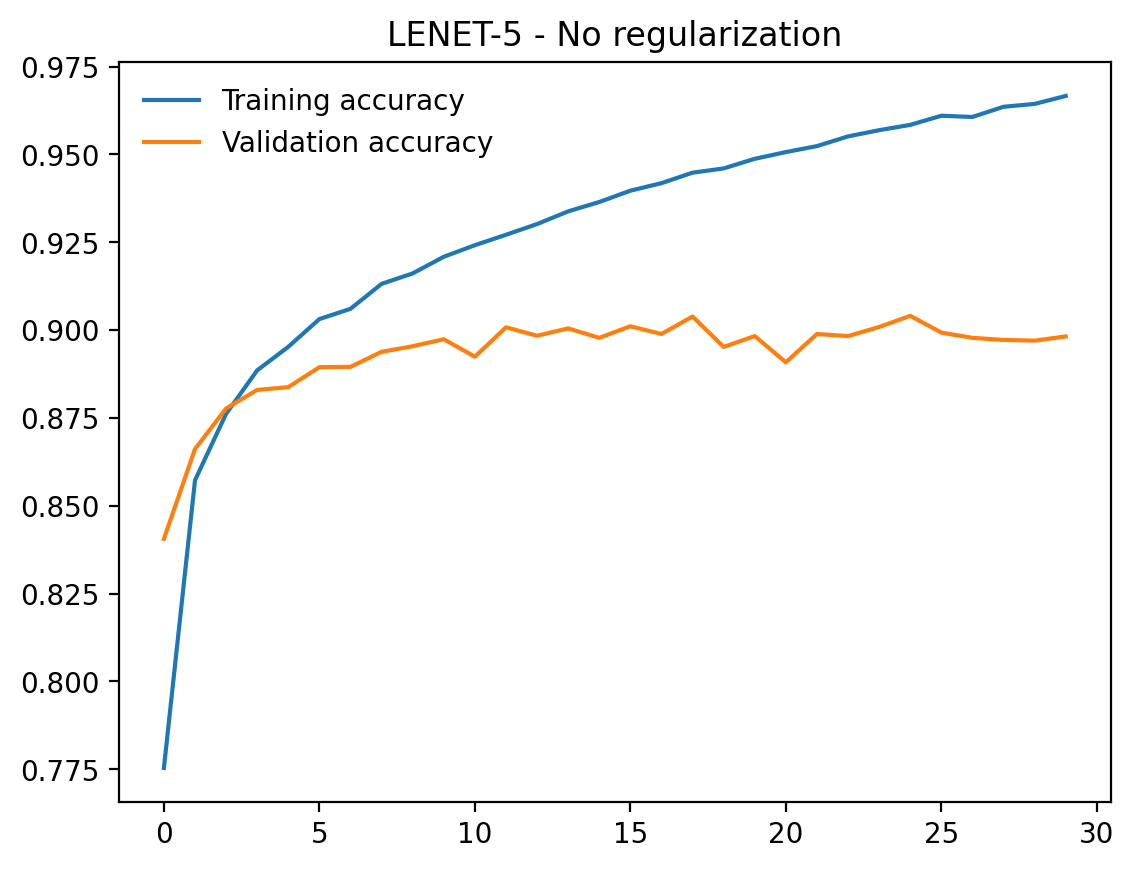

In [ ]:
plt.plot(accuracy_train_lenet5, label='Training accuracy')
plt.plot(accuracy_test_lenet5, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('LENET-5 - No regularization')

Text(0.5, 1.0, 'LENET-5 with Weight Decay')

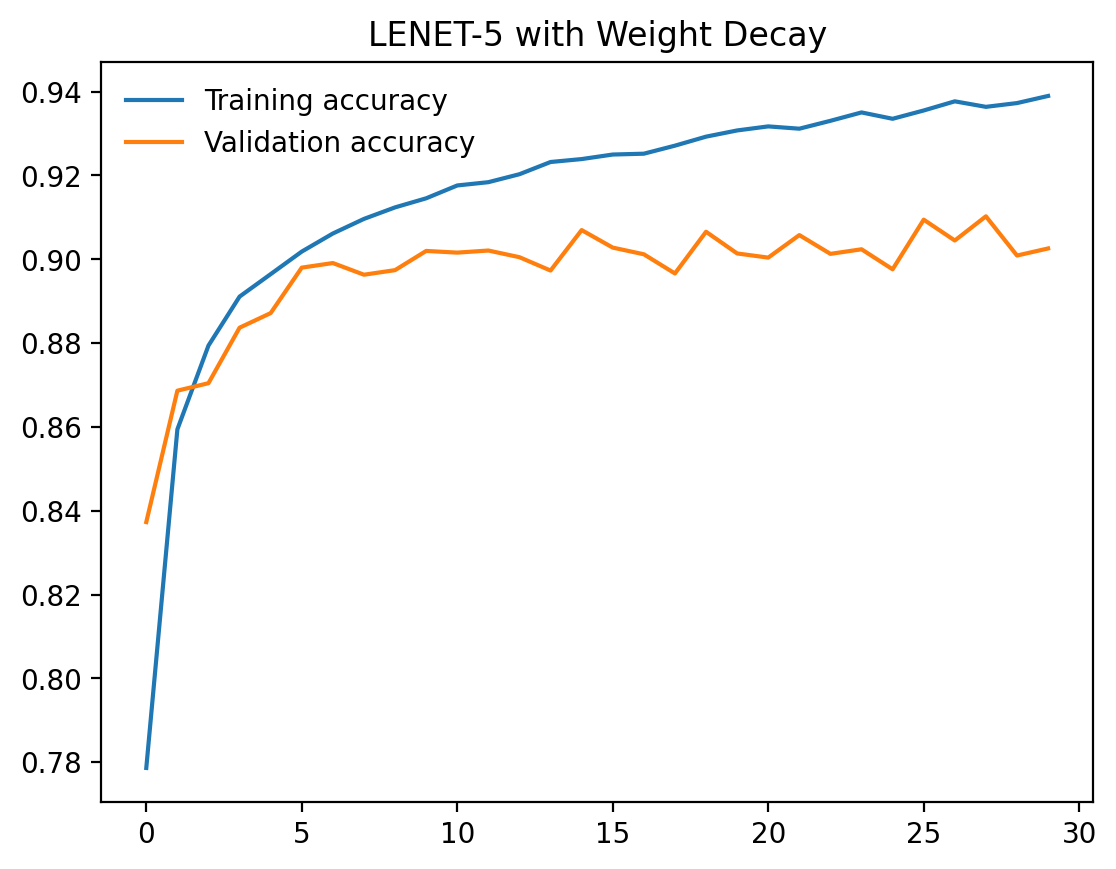

In [ ]:
plt.plot(accuracy_train_wd, label='Training accuracy')
plt.plot(accuracy_test_wd, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('LENET-5 with Weight Decay')

Text(0.5, 1.0, 'LENET-5 with Dropout')

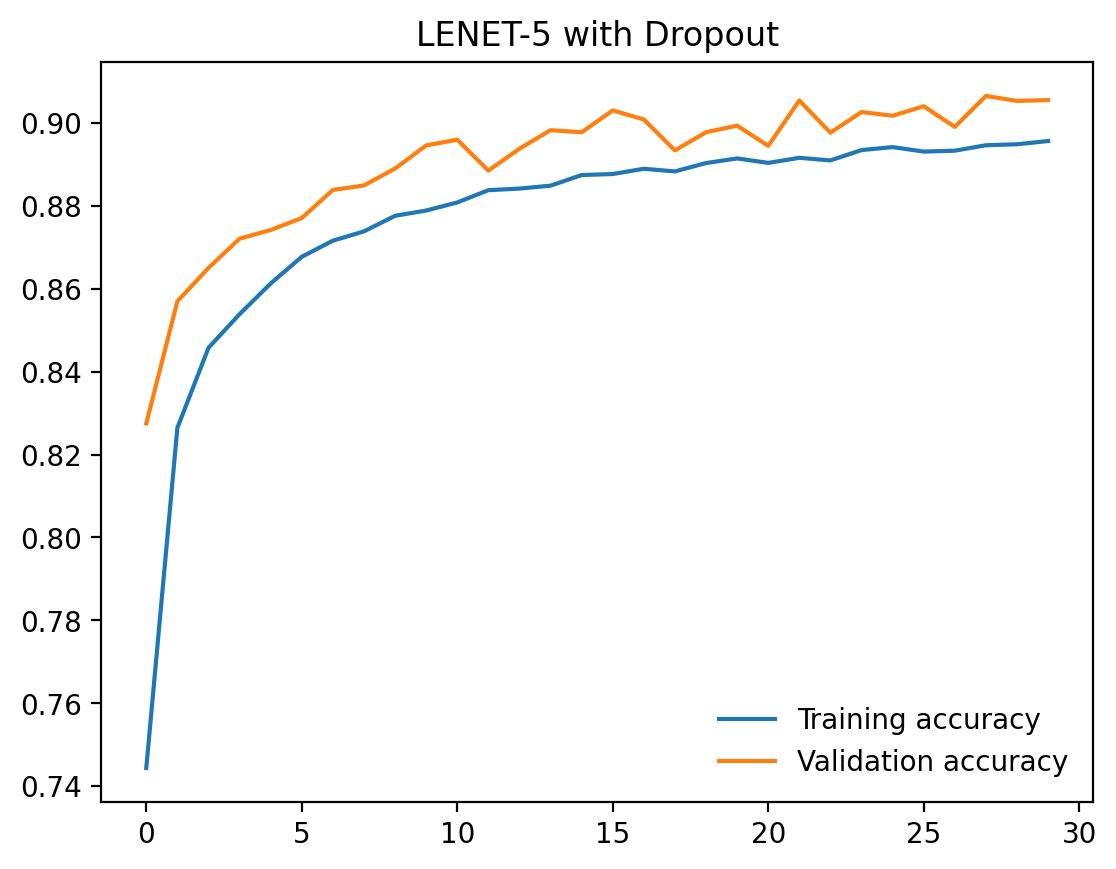

In [ ]:
plt.plot(accuracy_train_dropout, label='Training accuracy')
plt.plot(accuracy_test_dropout, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('LENET-5 with Dropout')

Text(0.5, 1.0, 'LENET-5 with Batch Normaliztion')

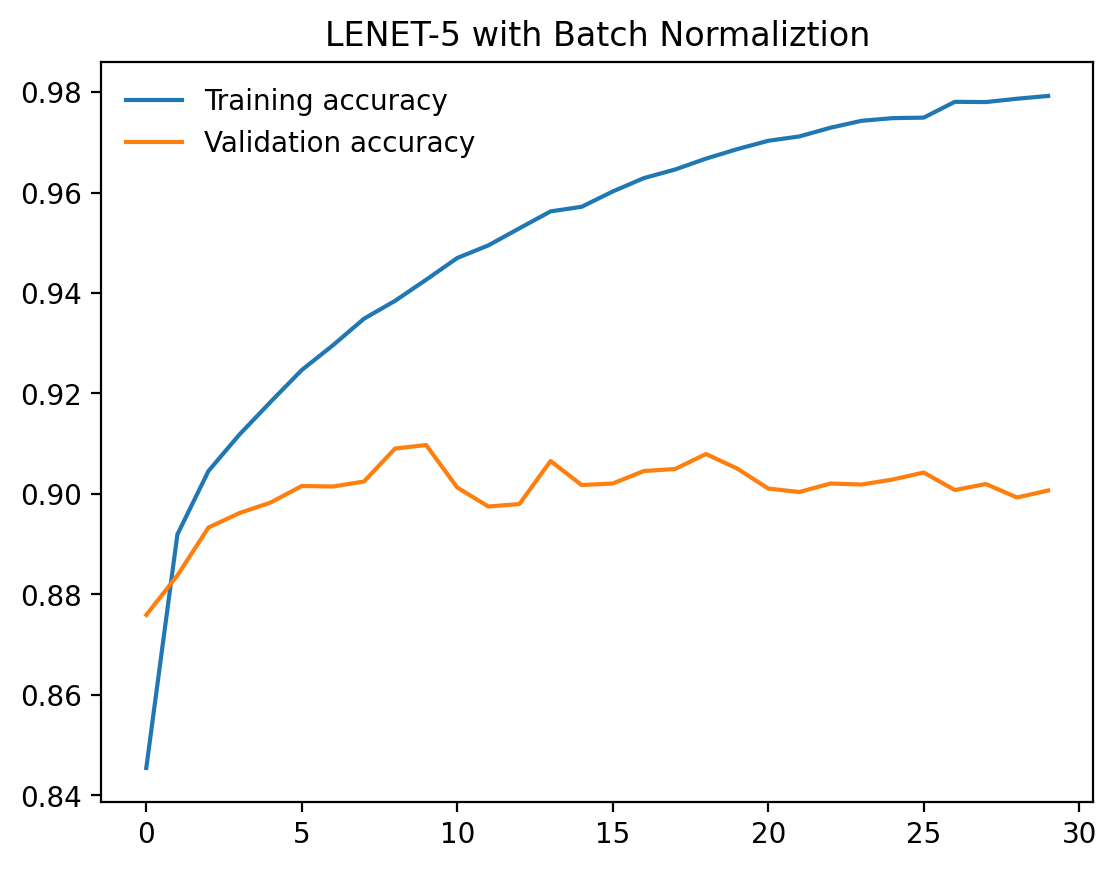

In [ ]:
plt.plot(accuracy_train_bn, label='Training accuracy')
plt.plot(accuracy_test_bn, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('LENET-5 with Batch Normaliztion')

In [ ]:
# Summary in a table
import numpy as np
from tabulate import tabulate


data = [['', 'No Regularization', 'Weight Decay', 'Dropout', 'Batch Normalization'],
        ['Train accuracy [%]', accuracy_train_lenet5[np.argmax(accuracy_test_lenet5)]*100, accuracy_train_wd[np.argmax(accuracy_test_wd)]*100, accuracy_train_dropout[np.argmax(accuracy_test_dropout)]*100, accuracy_train_bn[np.argmax(accuracy_test_bn)]*100],
        ['Test accuracy [%]', max(accuracy_test_lenet5)*100, max(accuracy_test_wd)*100, max(accuracy_test_dropout)*100, max(accuracy_test_bn)*100]]

print(tabulate(data, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤═════════════════════╤════════════════╤═══════════╤═══════════════════════╕
│                    │   No Regularization │   Weight Decay │   Dropout │   Batch Normalization │
╞════════════════════╪═════════════════════╪════════════════╪═══════════╪═══════════════════════╡
│ Train accuracy [%] │             95.8405 │        93.6351 │   89.4656 │               94.2647 │
├────────────────────┼─────────────────────┼────────────────┼───────────┼───────────────────────┤
│ Test accuracy [%]  │             90.4061 │        91.0231 │   90.6549 │               90.9733 │
╘════════════════════╧═════════════════════╧════════════════╧═══════════╧═══════════════════════╛


## Conclusion
According to the accuracy table, it seems that Weight decay is slightly better than the other methods.
The diffrences are small.